# Project : The price fluctuations of bitcoin

### (1) Loading local file into python environment

We have already excuted [Bitcoin_1_Download_Data.ipynb](https://github.com/LeiZHANG1995/PHBS_TQFML/blob/master/Project/Bitcoin_1_Download_Data.ipynb) file, and we have a [Bitcoin_data.csv](https://github.com/LeiZHANG1995/PHBS_TQFML/blob/master/Project/Bitcoin_data.csv) file under current path. Let's load the data into python environment:

In [12]:
import numpy as np
import pandas as pd

df = pd.read_csv("./Bitcoin_data.csv")
df.head()

,date,price,supply,capital,trade,wiki
0,2017-05-07,1535.868429,16316762.5,2.506040e+10,6.249247e+07,17777
1,2017-05-08,1640.619225,16319012.5,2.677329e+10,1.396276e+08,19666
2,2017-05-09,1721.284971,16320950.0,2.809301e+10,1.675120e+08,23935
3,2017-05-10,1762.886250,16322800.0,2.877524e+10,1.318174e+08,24385
4,2017-05-11,1820.990562,16324487.5,2.972674e+10,1.515058e+08,25185


First of all, we need to display the data, and to find some interesting features:

In [13]:
#"trade" is the total USD value of trading volume on major bitcoin exchanges, 
#We need to divide it with price to get rid of the influence of price.
trade2 = df.trade / df.price
trade2.name = "trade2"

#explained variable is price, explanatory variables are trade and wiki.
ln_price = np.log(df.price)
ln_trade = np.log(df.trade)
ln_trade2 = np.log(trade2)
ln_wiki = np.log(df.wiki)

### (2) Let's try to draw some patterns from the data

Now, we first generate an explained variable, `y`, from the `price` attribute of dataframe `df`. We map the current price of bitcoin into a binary variable, 1 for 'going up' and -1 for 'going down', compared with the previous price. 

Also, we extract the explanary variables from dataframe `df`, and store them into a numpy array. We want to figure out the relation pattern of 'up' and 'down' with those explanatory variables.

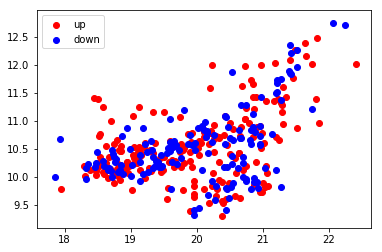

In [29]:
import matplotlib.pyplot as plt

#map explained variable y into a binary variable
y = df.price
y = y.diff()
y[y>0] = 1
y[y<0] = -1
y = y.values[1:len(y)-1]

#input trade and wiki as explanatory variables
attr1 = 'trade'
attr2 = 'wiki'
X = df.loc[0: len(y), [attr1, attr2]]

#plot y and x to find some patterns from data
plt.scatter(np.log(X.loc[y>=0, attr1]).values, np.log(X.loc[y>=0, attr2]).values, c = 'r')
plt.scatter(np.log(X.loc[y<0, attr1]).values, np.log(X.loc[y<0, attr2]).values, c = 'b')
plt.legend(('up', 'down'), loc = 'best')
plt.show()

#### It seems we are in big trouble in predicting the price functuation!
Because there isn't any significant pattern that we are able to draw linearly from the figure above. It seems all the classical linear algorithms that we have learnt from the textbooks are invalid under this senario. We need to find some other ways to do prediction.

### (3) Using Time Series Models: ADL(autogressive dynamic lag) model

From the economietrics course, we know the best time series model in the viewfield of econometrics is ADL model, which is given in this form:

$$Y_t = \beta (1+L+L^2+...+L^{p-1})Y_{t-1}+\alpha (1+L+L^2+...+L^{p-1})X_{t-1}$$

Will ADL model have a better performance in our case? Let find out. We have alredy written all the codes in the [LSTM.py](https://github.com/LeiZHANG1995/PHBS_TQFML/blob/master/Project/LSTM.py) file (please check the file and look through our algorithms and ideas), and here we just display the result.

First, we split the total data into training sample and test sample:

In [15]:
#import function from LSYM.py file
from LSTM import Predictor
from LSTM import Utils

X = pd.DataFrame({'ln_trade':ln_trade, 'ln_trade2':ln_trade2, 'ln_wiki':ln_wiki})
p = Predictor()

The accuracy for Pooled ADL : 

In [16]:
#define a function for performance evaluation of ADL
def ADL_Performance(sample_training, lag):
    train_set_X = X[:sample_training] 
    train_set_Y = ln_price[:sample_training]
    test_set_X = X[sample_training:]
    test_set_Y = ln_price[sample_training:]
    ## (1) Train pure ADL
    p.ADL_fit(train_set_Y, train_set_X, lag)
    re_train = p.ADL_predict_accuracy(train_set_Y, train_set_X, lag)
    train_accu = re_train['accuracy']
    ## (2) Test pure ADL
    re_test = p.ADL_predict_accuracy(test_set_Y, test_set_X, lag)
    test_accu =re_test['accuracy']
    return train_accu, test_accu

Find the optimal `lag` order

In [31]:
train_accus = []
test_accus = []
orders = []

#split train set and test set, randomly choose 200 samples as train set
sample_size = 200

# find the optimal lag order by doing loop，here i is lag order
for i in range(1, 21):
    orders.append(i)
    t1, t2 = ADL_Performance(200, i)
    train_accus.append(t1)
    test_accus.append(t2)

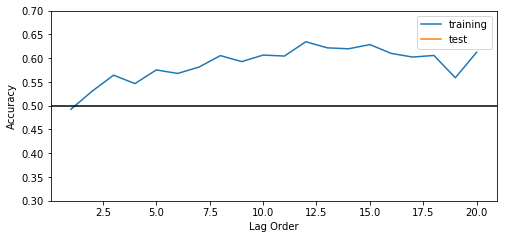

In [32]:
# plot lag order against training and test accuracy for hyperparameter tuning for ADL model
fig = plt.gcf()
fig.set_size_inches(8, 3.5)
plt.plot(orders, train_accus)
plt.plot(orders, test_accus)
plt.xlabel('Lag Order')
plt.ylabel('Accuracy')
plt.ylim([0.3, 0.7])
plt.axhline(0.5, color = 'black')
plt.legend(('training', 'test'))
plt.show()

Does this model sensitive to the training size? Let's find out.

In [33]:
#calculate accuracy when changing sample sizes
train_accus = []
test_accus = []
samples = []
lag = 2

for s in range(150, 300):
    samples.append(s)
    t1, t2 = ADL_Performance(s, lag)
    train_accus.append(t1)
    test_accus.append(t2)

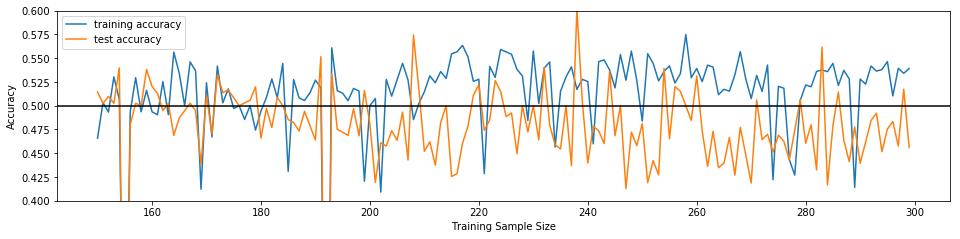

In [21]:
#plot learning curves for ADL
fig = plt.gcf()
fig.set_size_inches(16, 3.5)
plt.plot(samples, train_accus)
plt.plot(samples, test_accus)
plt.xlabel('Training Sample Size')
plt.ylabel('Accuracy')
plt.ylim([0.4, 0.6])
plt.axhline(0.5, color = 'black')
plt.legend(('training accuracy', 'test accuracy'), loc = 'best')
plt.show()

### (4) Using LSTM (long and short term memory) Model

Now, let's use another method to do prediction. This method is inspired from the LSTM(long and short term memory) model, which is a hot deep learning topic. The idea is similar, so I name this method LSTM model.

We have written all the code of this method in [LSTM.py](https://github.com/LeiZHANG1995/PHBS_TQFML/blob/master/Project/LSTM.py) file, and here we just call the method and display the result.

In [22]:
def LSTM_performance(sample_training, window, lag):
    
    train_set_X = X[:sample_training] 
    train_set_Y = ln_price[:sample_training]
    test_set_X = X[sample_training:]
    test_set_Y = ln_price[sample_training:]
    
    train_re = p.LSTM_fit(train_set_Y, train_set_X, lag, window)
    
    nperf1 = np.array(train_re['ADL_accuracy'])
    nperf2 = np.array(train_re['LR_accuracy'])
    Avg_train_accu_adl = nperf1.mean()
    Avg_train_accu_lstm = nperf2.mean()
    
    test_re = p.LSTM_predict_accuracy(test_set_Y, test_set_X, lag, window)
    test_accu = test_re['accuracy']
    return Avg_train_accu_adl, Avg_train_accu_lstm, test_accu

Find the optimal `window`.

In [23]:
#randomly select 200 samples as train set
sample_training = 200
lag = 2

avg_train_accu_adl = []
avg_train_accu_lstm = []
test_accus = []
windows = []

# fina the optimal value for window. Here w is window
for w in range(30, 70):
    windows.append(w)
    t1, t2, t3 = LSTM_performance(sample_training, w, lag)
    avg_train_accu_adl.append(t1)
    avg_train_accu_lstm.append(t2)
    test_accus.append(t3)

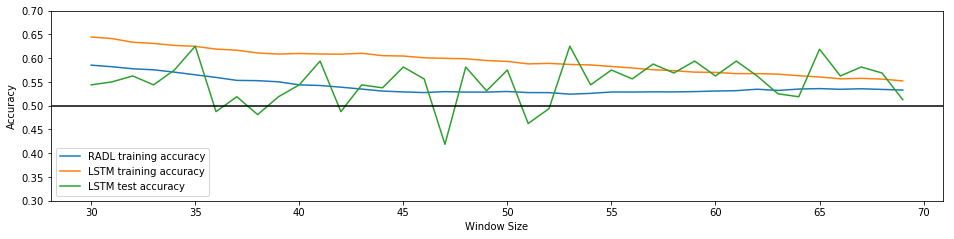

In [24]:
#plot window size against accuracy for hyperparameter tuning
fig = plt.gcf()
fig.set_size_inches(16, 3.5)
plt.plot(windows, avg_train_accu_adl)
plt.plot(windows, avg_train_accu_lstm)
plt.plot(windows, test_accus)
plt.xlabel('Window Size')
plt.ylabel('Accuracy')
plt.ylim([0.3, 0.7])
plt.axhline(0.5, color = 'black')
plt.legend(('RADL training accuracy', 'LSTM training accuracy', 'LSTM test accuracy'))
plt.show()

Find the optimal `lag` order.

In [25]:
# find the optimal lag order by doing loop，here i is lag order
sample_training = 200
window = 50

avg_train_accu_adl = []
avg_train_accu_lstm = []
test_accus = []
orders = []

for i in range(1, 9):
    orders.append(i)
    t1, t2, t3 = LSTM_performance(sample_training, window, i)
    avg_train_accu_adl.append(t1)
    avg_train_accu_lstm.append(t2)
    test_accus.append(t3)

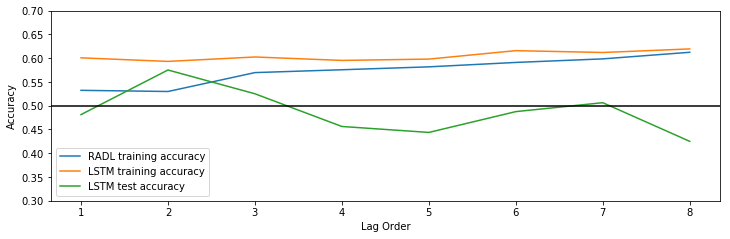

In [26]:
#plot lag order against accuracy for hyperparameter tuning
fig = plt.gcf()
fig.set_size_inches(12, 3.5)
plt.plot(orders, avg_train_accu_adl)
plt.plot(orders, avg_train_accu_lstm)
plt.plot(orders, test_accus)
plt.xlabel('Lag Order')
plt.ylabel('Accuracy')
plt.ylim([0.3, 0.7])
plt.axhline(0.5, color = 'black')
plt.legend(('RADL training accuracy', 'LSTM training accuracy', 'LSTM test accuracy'))
plt.show()

Does this result sensitive to the training size? Let's find out.

In [27]:
#calculate accuracy when changing sample sizes
avg_train_accu_adl = []
avg_train_accu_lstm = []
test_accus = []
samples = []
window = 50
lag = 2

for s in range(150, 300):
    samples.append(s)
    t1, t2, t3 = LSTM_performance(s, window, lag)
    avg_train_accu_adl.append(t1)
    avg_train_accu_lstm.append(t2)
    test_accus.append(t3)

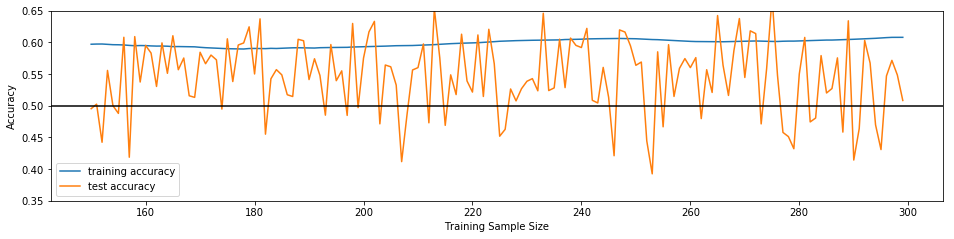

In [28]:
#plot learning curve
fig = plt.gcf()
fig.set_size_inches(16, 3.5)
plt.plot(samples, avg_train_accu_lstm)
plt.plot(samples, test_accus)
plt.xlabel('Training Sample Size')
plt.ylabel('Accuracy')
plt.ylim([0.35, 0.65])
plt.axhline(0.5, color = 'black')
plt.legend(('training accuracy', 'test accuracy'), loc = 'best')
plt.show()

### (5) Conclusion

Pooled ADL is stationary, and does not face overfitting problem. But the accuracy is just a little bit higher than 0.5, which is not a good performance.

LSTM is very sensitive to the input parameters, and the model can be overfitting in many cases, but it predict well under some optimal parameters.